In [1]:
!pip install torch torchvision timm transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.5 MB/s eta 0:00:00


In [2]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
import urllib.request

from timm import create_model
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CIFAR100, SVHN, MNIST
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
from transformers import CLIPProcessor, CLIPModel
# from kaggle_datasets import KaggleDatasets
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
def create_vit_model(num_classes):
    """Create a ViT model with a dynamic number of output classes."""
    model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

    #Freeze all layers in the VIT model
    for param in model.parameters():
        param.requires_grad = False
    # Replace the classifier head
    model.head = torch.nn.Linear(model.head.in_features, num_classes)
    return model

def create_vgg_model(num_classes):
    """Create a VGG model with a dynamic number of output classes."""
    model = vgg16(pretrained=True)
    # Freeze all layers in the VGG model
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Modify the final classifier layer to match the number of classes
    return model


def fine_tune_model(model, train_loader, num_epochs=3, alpha=1e-3):
    """Fine-tune the discriminative models on the training data."""
    print("Finetuning the discriminative model on this data")

    # Ensure the model is on the correct device
    model.to(device)
    model.train()

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure inputs are on the correct device

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
def init_models(num_classes):
    """Initialize ViT, VGG, and CLIP models with a dynamic number of output classes."""
    vit_model = create_vit_model(num_classes)
    vgg_model = create_vgg_model(num_classes)
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return vit_model, vgg_model, clip_model, clip_processor

In [5]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])


dataset_path = './data'  # Change the path to a writeable location
cifar10_train_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform)
cifar10_test_dataset = CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size= 32, shuffle= True)

cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=32, shuffle=False)
cifar10_clip_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

print(f'Total number of images in CIFAR 10 test_loader: {len(cifar10_test_loader)}')


100%|██████████| 170498071/170498071 [00:12<00:00, 13269673.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Total number of images in CIFAR 10 test_loader: 313


In [6]:
def evaluate_model(model, data_loader,device):
    """Evaluate the discriminative models using a basic testing loop"""
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    num_batches = len(data_loader)  # Get total number of batches

    with torch.no_grad():
        for batch_index, (images, labels) in enumerate(data_loader):

            batch_size = images.size(0)
            if batch_size < 32:
              print(f"skipping last batch of size {batch_size} --- gives shape error")
              break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Print progress every 10 batches (you can adjust this as needed)
            if batch_index % 10 == 0:
                print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    print(f'Final Accuracy: {accuracy * 100:.2f}%')
    return accuracy


def get_text_features(class_names):
    """Generate text embeddings for the given class names using CLIP."""
    # Ensure inputs are moved to the device
    inputs = clip_processor(text=class_names, return_tensors="pt", padding=True).to(device)

    # Make sure the model is on the same device
    clip_model.to(device)

    with torch.no_grad():
        # Get the text features from the model
        text_features = clip_model.get_text_features(**inputs)

    return text_features


def denormalize(image, mean, std):
    """Reverse the normalization applied to an image."""
    # Move mean and std to the same device as the image
    mean = torch.tensor(mean).view(3, 1, 1).to(image.device)
    std = torch.tensor(std).view(3, 1, 1).to(image.device)

    # Reverse the normalization
    image = image * std + mean  # Reverse normalization
    return torch.clamp(image, 0, 1)  # Clip the values to be in range [0, 1]



to_pil = transforms.ToPILImage() # Convert Tensor to PIL Image for CLIP model

def predict_image(image, means, stds):
    """Predict the class of a single image using CLIP."""
    image = image.to(device)  # Ensure the image is on the correct device

    # If the image has a batch dimension (4D), remove it
    if image.dim() == 4:  # Shape [B, C, H, W], remove batch dimension
        image = image.squeeze(0)

    # Denormalize the image and convert it to PIL
    image = to_pil(denormalize(image, means, stds))

    # Preprocess the image with CLIP's processor and move it to the correct device
    inputs = clip_processor(images=image, return_tensors="pt").to(device)

    # Get image features using CLIP's image encoder
    with torch.no_grad():
        image_features = clip_model.get_image_features(inputs.pixel_values)

    return image_features





def evaluate_clip_model(data_loader, class_names,device, means, stds):
    """Evaluate the zero shot CLIP model using similairty matrix and loss func (no training)"""
    text_features = get_text_features(class_names)
    correct = 0
    total = 0
    num_batches = len(data_loader)  # Get total number of batches

    for batch_index, (images, labels) in enumerate(data_loader):
        image = images[0]  # For batch size 1
        true_label = labels[0].item()
        image_features = predict_image(image,means,stds)

        # Compute similarity between image and all text features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        similarity = torch.matmul(image_features, text_features.T)

        # Predict the class
        predicted_class = similarity.argmax().item()
        if predicted_class == true_label:
            correct += 1
        total += 1

        # Print progress every 500 batches (you can adjust this as needed)
        if batch_index % 500 == 0:
            print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    return accuracy

In [7]:
cifar10_vit_model, cifar10_vgg_model, clip_model, clip_processor = init_models(num_classes=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 162MB/s]


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
print('Evaluating the Discriminative Models...')
print("Finetuning Vit model")
fine_tune_model(cifar10_vit_model,cifar10_train_loader)
# print(f"ViT Train Accuracy on CIFAR 10: {vit_train_accuracy * 100:.2f}%")

cifar10_vit_accuracy = evaluate_model(cifar10_vit_model, cifar10_test_loader,device)
print(f"ViT Accuracy on CIFAR 10: {cifar10_vit_accuracy * 100:.2f}%")


Evaluating the Discriminative Models...
Finetuning Vit model
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 0.1809
Epoch [2/3], Loss: 0.1267
Epoch [3/3], Loss: 0.1147
Batch 1/313 - Accuracy: 100.00%
Batch 11/313 - Accuracy: 94.89%
Batch 21/313 - Accuracy: 95.09%
Batch 31/313 - Accuracy: 96.07%
Batch 41/313 - Accuracy: 95.81%
Batch 51/313 - Accuracy: 95.59%
Batch 61/313 - Accuracy: 95.44%
Batch 71/313 - Accuracy: 95.33%
Batch 81/313 - Accuracy: 95.33%
Batch 91/313 - Accuracy: 95.16%
Batch 101/313 - Accuracy: 94.99%
Batch 111/313 - Accuracy: 94.93%
Batch 121/313 - Accuracy: 94.94%
Batch 131/313 - Accuracy: 95.01%
Batch 141/313 - Accuracy: 95.17%
Batch 151/313 - Accuracy: 95.01%
Batch 161/313 - Accuracy: 95.03%
Batch 171/313 - Accuracy: 95.08%
Batch 181/313 - Accuracy: 95.20%
Batch 191/313 - Accuracy: 95.11%
Batch 201/313 - Accuracy: 95.10%
Batch 211/313 - Accuracy: 95.16%
Batch 221/313 - Accuracy: 95.22%
Batch 231/313 - Accuracy: 95.29%
Batch 241/313 - Accuracy: 95.2

In [8]:
print("Finetuning vgg model")
fine_tune_model(cifar10_vgg_model,cifar10_train_loader)
# print(f"Vgg Train Accuracy on CIFAR 10: {vgg_train_accuracy * 100:.2f}%")
cifar10_vgg_accuracy = evaluate_model(cifar10_vgg_model, cifar10_test_loader,device)
print(f"VGG Accuracy on CIFAR 10: {cifar10_vgg_accuracy * 100:.2f}%")

Finetuning vgg model
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 0.8789
Epoch [2/3], Loss: 0.6772
Epoch [3/3], Loss: 0.5693
Batch 1/313 - Accuracy: 100.00%
Batch 11/313 - Accuracy: 84.66%
Batch 21/313 - Accuracy: 86.01%
Batch 31/313 - Accuracy: 85.99%
Batch 41/313 - Accuracy: 86.20%
Batch 51/313 - Accuracy: 85.97%
Batch 61/313 - Accuracy: 86.01%
Batch 71/313 - Accuracy: 85.78%
Batch 81/313 - Accuracy: 85.61%
Batch 91/313 - Accuracy: 85.71%
Batch 101/313 - Accuracy: 85.55%
Batch 111/313 - Accuracy: 85.73%
Batch 121/313 - Accuracy: 85.69%
Batch 131/313 - Accuracy: 85.76%
Batch 141/313 - Accuracy: 85.93%
Batch 151/313 - Accuracy: 85.84%
Batch 161/313 - Accuracy: 85.93%
Batch 171/313 - Accuracy: 85.80%
Batch 181/313 - Accuracy: 85.84%
Batch 191/313 - Accuracy: 85.75%
Batch 201/313 - Accuracy: 85.87%
Batch 211/313 - Accuracy: 85.93%
Batch 221/313 - Accuracy: 85.77%
Batch 231/313 - Accuracy: 85.89%
Batch 241/313 - Accuracy: 85.83%
Batch 251/313 - Accuracy: 85.71%
Batc

In [9]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print('Evaluating the Contrastive Model...')
cifar10_clip_accuracy = evaluate_clip_model(cifar10_clip_test_loader, cifar10_classes, device, means=(0.4914, 0.4822, 0.4465),stds=(0.247, 0.2435, 0.2616))
print(f'CLIP (Zero-Shot) Accuracy on CIFAR 10: {cifar10_clip_accuracy * 100:.2f}%')

Evaluating the Contrastive Model...
Batch 1/10000 - Accuracy: 0.00%
Batch 501/10000 - Accuracy: 84.43%
Batch 1001/10000 - Accuracy: 85.21%
Batch 1501/10000 - Accuracy: 85.88%
Batch 2001/10000 - Accuracy: 86.36%
Batch 2501/10000 - Accuracy: 86.13%
Batch 3001/10000 - Accuracy: 85.67%
Batch 3501/10000 - Accuracy: 85.63%
Batch 4001/10000 - Accuracy: 85.65%
Batch 4501/10000 - Accuracy: 85.56%
Batch 5001/10000 - Accuracy: 85.42%
Batch 5501/10000 - Accuracy: 85.24%
Batch 6001/10000 - Accuracy: 85.17%
Batch 6501/10000 - Accuracy: 84.85%
Batch 7001/10000 - Accuracy: 84.65%
Batch 7501/10000 - Accuracy: 84.87%
Batch 8001/10000 - Accuracy: 84.96%
Batch 8501/10000 - Accuracy: 85.03%
Batch 9001/10000 - Accuracy: 84.97%
Batch 9501/10000 - Accuracy: 85.01%
CLIP (Zero-Shot) Accuracy on CIFAR 10: 85.00%


In [13]:
!pip install gdown
import gdown
import zipfile
import os

def download_and_extract_zip(google_drive_link, output_filename, extract_folder):
    """
    Downloads a zip file from Google Drive and extracts its contents.

    Args:
    - google_drive_link (str): The Google Drive link to the file.
    - output_filename (str): The name for the downloaded zip file.
    - extract_folder (str): The path to extract the zip contents.

    Returns:
    - None
    """
    # Download the zip file
    gdown.download(google_drive_link, output_filename, quiet=False)

    # Create the extraction folder if it doesn't already exist
    os.makedirs(extract_folder, exist_ok=True)

    # Manually unzip the contents into the extraction folder
    with zipfile.ZipFile(output_filename, 'r') as zip_ref:
        # List the contents of the zip file
        file_list = zip_ref.namelist()
#         print(f"Contents of the zip file: {file_list}")

        # Extract the contents to the specified folder
        zip_ref.extractall(extract_folder)

    # Verify that the files are extracted
    print(f"Contents of the extraction folder: {os.listdir(extract_folder)}")




# Loading scrambled dataset

In [14]:
# Corrected Google Drive link
# https://drive.google.com/drive/folders/1Gtd7NavV3dQS2MSrRGsrZFNRaSQwCR0D?usp=drive_link
# https://drive.google.com/file/d/1ZGCB9UfT7J9khgYVyU-mmFko7W-dy7zd/view?usp=drive_link
google_drive_link = "https://drive.google.com/uc?id=1ZGCB9UfT7J9khgYVyU-mmFko7W-dy7zd"
output_filename = '/content/scrambled_dataset.zip'
extract_folder = '/content/scrambled_dataset'

download_and_extract_zip(google_drive_link, output_filename, extract_folder)

Downloading...
From (original): https://drive.google.com/uc?id=1ZGCB9UfT7J9khgYVyU-mmFko7W-dy7zd
From (redirected): https://drive.google.com/uc?id=1ZGCB9UfT7J9khgYVyU-mmFko7W-dy7zd&confirm=t&uuid=0be0c483-53aa-4be7-a0d4-79545c011120
To: /content/scrambled_dataset.zip
100%|██████████| 120M/120M [00:03<00:00, 33.0MB/s]


Contents of the extraction folder: ['content']


In [15]:
labels_output ="/content/scrambled_dataset/content/generated_dataset/labels.txt"
# Parse the labels file into a dictionary
labels_dict = {}

with open(labels_output, 'r') as file:
    for line in file:
        filename, label = line.strip().split()  # Split the filename and label by space
        labels_dict[filename] = int(label)  # Store the label as an integer

# labels_dict

<ipython-input-17-a8392f00c61f>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


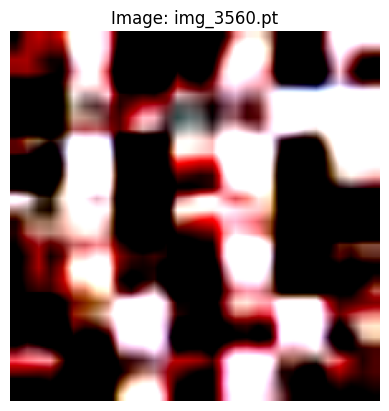

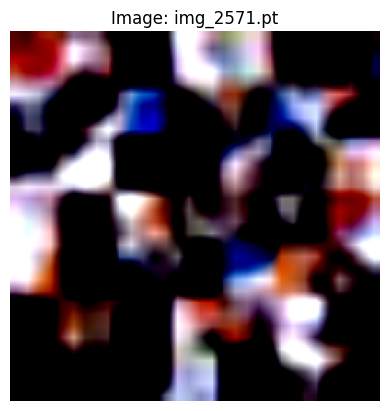

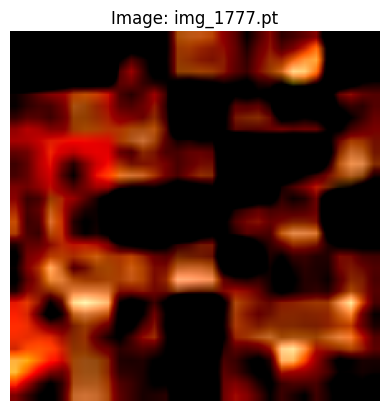

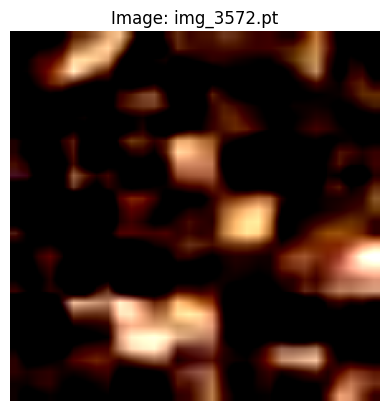

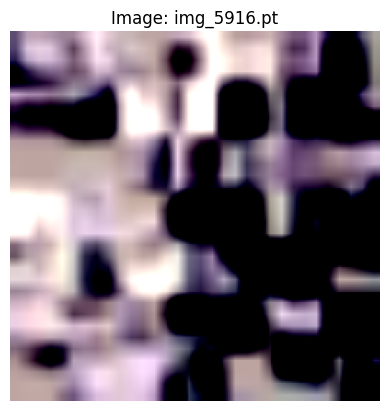

In [17]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Function to load, display, and store tensor images from a folder
# Function to load, resize, and display tensor images
def load_and_display_images(tensors_folder, display_limit=5):
    """
    Loads, resizes, and displays images from tensor files in a given folder.
    Also stores the loaded images as tensors for future use.

    Args:
    - tensors_folder (str): Path to the folder containing tensor files.
    - display_limit (int): Number of images to display.

    Returns:
    - loaded_tensors (list): List of loaded and resized image tensors.
    """

    # Transform to resize the tensor directly
    resize = transforms.Resize((224, 224))  # Resize to 224x224

    # List to store the loaded image tensors
    loaded_tensors = []

    # List all .pt files in the folder
    tensor_files = [f for f in os.listdir(tensors_folder) if f.endswith('.pt')]

    # Loop through and load all the tensor images, but display only the first `display_limit` images
    for i, tensor_file in enumerate(tensor_files):
        tensor_path = os.path.join(tensors_folder, tensor_file)

        # Load the tensor
        tensor_image = torch.load(tensor_path)

        # Remove extra batch dimension if present
        if tensor_image.dim() == 4:
            tensor_image = tensor_image.squeeze(0)

        # Resize the tensor to 224x224
        tensor_image = resize(tensor_image)

        # Store the resized tensor
        loaded_tensors.append(tensor_image)

        # Convert tensor to numpy array for displaying
        image_array = tensor_image.permute(1, 2, 0).cpu().numpy()  # Convert from CHW to HWC

        # Display only up to `display_limit` images
        if i < display_limit:
            plt.imshow(image_array)
            plt.title(f"Image: {tensor_file}")
            plt.axis('off')
            plt.show()
        else:
            break  # Stop after displaying `display_limit` images

    return loaded_tensors

# Example usage
tensors_folder = "/content/scrambled_dataset/content/generated_dataset/images"
loaded_tensors_scrambled_cifar10 = load_and_display_images(tensors_folder, display_limit=5)

# You can now use the `loaded_tensors` for input to the model


In [18]:
from sklearn.metrics import accuracy_score
# Function to preprocess tensors (apply resizing and normalization)
resize_transform = transforms.Resize((224, 224))  # Resize transform

normalize_transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

def preprocess_tensor(tensor_image):
    # Resize and normalize the tensor images
    if tensor_image.dim() == 4:  # Remove batch dimension if present
        tensor_image = tensor_image.squeeze(0)

    # Resize to 224x224 (if needed)
    tensor_image = resize_transform(tensor_image)

    # Apply normalization only
    tensor_image = normalize_transform(tensor_image)

    # Add batch dimension back for model input
    return tensor_image.unsqueeze(0).to(device)

# Function to evaluate model on custom images with ground truth labels
def evaluate_model_on_custom_images(model, model_name, labels_dict, tensor_files, tensors_folder):
    model.to(device)  # Move the model to the same device as the data
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    ground_truth_labels = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for tensor_file in tensor_files:
            tensor_path = os.path.join(tensors_folder, tensor_file)

            # Load the tensor (already loaded as a PyTorch tensor)
            tensor_image = torch.load(tensor_path)

            # Preprocess the image (resize, normalize, and move to the correct device)
            processed_image = preprocess_tensor(tensor_image)

            # Pass through the model (ensure both the model and the input are on the same device)
            outputs = model(processed_image)

            # Get the predicted class (argmax to get the index of the highest score)
            _, predicted = outputs.max(1)
            predicted_class = predicted.item()
            all_predictions.append(predicted_class)

            # Get the ground truth label from the labels_dict using the tensor filename
            true_label = labels_dict[tensor_file]  # Ensure the tensor filename matches the keys in labels_dict
            ground_truth_labels.append(true_label)

    # Calculate accuracy
    accuracy = accuracy_score(ground_truth_labels, all_predictions)
    print(f"{model_name} Accuracy on Custom Images: {accuracy * 100:.2f}%")

    return accuracy


def evaluate_clip_model_on_custom_data(tensor_files, class_names, labels_dict, means, stds, device):
    """Evaluate the zero-shot CLIP model using the custom tensor data."""

    # Generate text embeddings for CIFAR-10 class names
    text_features = get_text_features(class_names)  # Function should generate CLIP text features
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize text embeddings

    correct = 0
    total = 0
    num_files = len(tensor_files)  # Total number of tensor files

    for i, tensor_file in enumerate(tensor_files):
        # Load the custom tensor image
        tensor_path = os.path.join(tensors_folder, tensor_file)
        tensor_image = torch.load(tensor_path).to(device)  # Load the tensor image and move to device

        # Get the true label for this image
        true_label = labels_dict[tensor_file]  # The correct label as an integer

        # Preprocess the image (apply CLIP preprocessing using predict_image)
        image_features = predict_image(tensor_image, means, stds)  # Preprocess and normalize image

        # Normalize image features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Compute similarity between image and all text features
        similarity = torch.matmul(image_features, text_features.T)

        # Predict the class (the index of the most similar text feature)
        predicted_class = similarity.argmax().item()

        # Compare prediction to ground truth
        if predicted_class == true_label:
            correct += 1
        total += 1

        # Print progress every 50 files (or adjust as needed)
        if i % 50 == 0:
            print(f'Processed {i+1}/{num_files} - Accuracy: { (correct/total) * 100:.2f}%')

    # Calculate final accuracy
    accuracy = correct / total
    return accuracy





In [19]:
tensors_folder = '/content/scrambled_dataset/content/generated_dataset/images'
tensor_files = [f for f in os.listdir(tensors_folder) if f.endswith('.pt')]

# accuracy = evaluate_model_on_custom_images(model, "Model Name", labels_dict, tensor_files, tensors_folder)

vit_accuracy_cifar10_scrambled=evaluate_model_on_custom_images(cifar10_vit_model, "ViT", labels_dict,tensor_files, tensors_folder)
print("Vit accuracy on Scrambled bias data",vit_accuracy_cifar10_scrambled)


vgg_accuracy_cifar10_scrambled = evaluate_model_on_custom_images(cifar10_vgg_model, "Vgg", labels_dict,tensor_files, tensors_folder)
print("Vgg accuracy on Scrambled bias data",vgg_accuracy_cifar10_scrambled)

<ipython-input-18-13f547395d0b>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


ViT Accuracy on Custom Images: 14.77%
Vit accuracy on Color bias data 0.1477


<ipython-input-18-13f547395d0b>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


Vgg Accuracy on Custom Images: 13.65%
Vgg accuracy on Color bias data 0.1365


In [20]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]




# Call the function for evaluation
# Make `device` a keyword argument:
clip_accuracy_scrambled_cifar10 = evaluate_clip_model_on_custom_data(tensor_files, cifar10_classes, labels_dict, means=(0.4914, 0.4822, 0.4465), stds=(0.247, 0.2435, 0.2616), device=device)

print(f"CLIP Accuracy on Scrambled Data: {clip_accuracy_scrambled_cifar10 * 100:.2f}%")

Processed 1/10000 - Accuracy: 0.00%


<ipython-input-18-13f547395d0b>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path).to(device)  # Load the tensor image and move to devi

Processed 51/10000 - Accuracy: 21.57%
Processed 101/10000 - Accuracy: 22.77%
Processed 151/10000 - Accuracy: 19.87%
Processed 201/10000 - Accuracy: 22.89%
Processed 251/10000 - Accuracy: 22.71%
Processed 301/10000 - Accuracy: 22.92%
Processed 351/10000 - Accuracy: 21.37%
Processed 401/10000 - Accuracy: 21.95%
Processed 451/10000 - Accuracy: 21.51%
Processed 501/10000 - Accuracy: 21.16%
Processed 551/10000 - Accuracy: 20.87%
Processed 601/10000 - Accuracy: 20.97%
Processed 651/10000 - Accuracy: 20.43%
Processed 701/10000 - Accuracy: 20.11%
Processed 751/10000 - Accuracy: 20.64%
Processed 801/10000 - Accuracy: 20.97%
Processed 851/10000 - Accuracy: 21.39%
Processed 901/10000 - Accuracy: 21.31%
Processed 951/10000 - Accuracy: 21.14%
Processed 1001/10000 - Accuracy: 21.18%
Processed 1051/10000 - Accuracy: 21.22%
Processed 1101/10000 - Accuracy: 20.98%
Processed 1151/10000 - Accuracy: 21.03%
Processed 1201/10000 - Accuracy: 21.07%
Processed 1251/10000 - Accuracy: 20.54%
Processed 1301/10000

In [21]:
vit_scrambled_bias = vit_accuracy_cifar10_scrambled/cifar10_vit_accuracy
vgg_scrambled_bias = vgg_accuracy_cifar10_scrambled/cifar10_vgg_accuracy
clip_scrambled_bias = clip_accuracy_scrambled_cifar10/cifar10_clip_accuracy



print('vit_color_bias',vit_scrambled_bias)
print('vgg_color_bias',vgg_scrambled_bias)
print('clip_color_bias',clip_scrambled_bias)

vit_color_bias 0.15499651040571788
vgg_color_bias 0.15917028731604765
clip_color_bias 0.2118823529411765


In [22]:
print('cifar10_vit_accuracy',cifar10_vit_accuracy)
print('cifar10_vgg_accuracy',cifar10_vgg_accuracy)
print('cifar10_clip_accuracy',cifar10_clip_accuracy)
print('vit_accuracy_cifar10_scrambled',vit_accuracy_cifar10_scrambled)
print("vgg_accuracy_cifar10_scrambled",vgg_accuracy_cifar10_scrambled)
print('clip_accuracy_scrambled_cifar10',clip_accuracy_scrambled_cifar10)

cifar10_vit_accuracy 0.9529246794871795
cifar10_vgg_accuracy 0.8575721153846154
cifar10_clip_accuracy 0.85
vit_accuracy_cifar10_scrambled 0.1477
vgg_accuracy_cifar10_scrambled 0.1365
clip_accuracy_scrambled_cifar10 0.1801


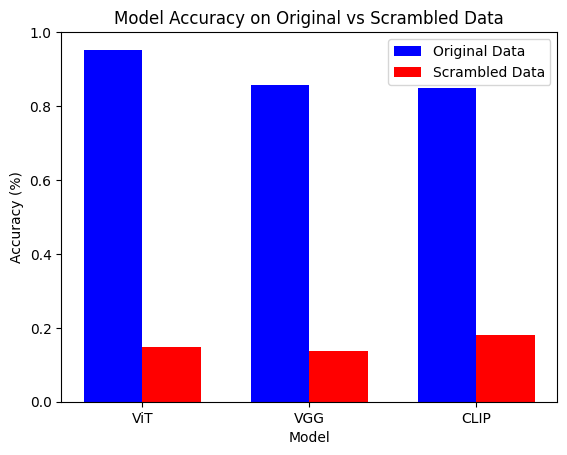

In [6]:
import matplotlib.pyplot as plt

# Bar Graph
models = ['ViT', 'VGG', 'CLIP']
# original_accuracies = [cifar10_vit_accuracy, cifar10_vgg_accuracy, cifar10_clip_accuracy]
# color_bias_accuracies = [vit_accuracy_cifar10_scrambled, vgg_accuracy_cifar10_scrambled, clip_accuracy_scrambled_cifar10]
original_accuracies = [0.9529246794871795, 0.8575721153846154, 0.85]
color_bias_accuracies = [0.1477, 0.1365, 0.1801]


x = range(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x, original_accuracies, width, label='Original Data', color='blue')
bar2 = ax.bar([i + width for i in x], color_bias_accuracies, width, label='Scrambled Data', color='red')

# Labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy on Original vs Scrambled Data')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(models)
ax.legend()

# Show the bar graph
plt.show()


Loading Noisy Dataset

In [24]:
# Corrected Google Drive link
# https://drive.google.com/drive/folders/1NqdEw2LSVibrNaC6HuVTHf8a1oaFkxM4?usp=drive_link
# https://drive.google.com/file/d/1pMFbq8aUx-p_6l6SQzjY-66DnC9z1BSn/view?usp=drive_link
google_drive_link = "https://drive.google.com/uc?id=1pMFbq8aUx-p_6l6SQzjY-66DnC9z1BSn"
output_filename = '/content/noisy_dataset.zip'
extract_folder = '/content/noisy_dataset'

download_and_extract_zip(google_drive_link, output_filename, extract_folder)

Downloading...
From (original): https://drive.google.com/uc?id=1pMFbq8aUx-p_6l6SQzjY-66DnC9z1BSn
From (redirected): https://drive.google.com/uc?id=1pMFbq8aUx-p_6l6SQzjY-66DnC9z1BSn&confirm=t&uuid=71d4d3db-8dce-4738-8684-89bbf917f404
To: /content/noisy_dataset.zip
100%|██████████| 337M/337M [00:11<00:00, 29.3MB/s]


Contents of the extraction folder: ['content']


In [25]:
labels_output ="/content/noisy_dataset/content/generated_dataset/labels.txt"
# Parse the labels file into a dictionary
labels_dict = {}

with open(labels_output, 'r') as file:
    for line in file:
        filename, label = line.strip().split()  # Split the filename and label by space
        labels_dict[filename] = int(label)  # Store the label as an integer

# labels_dict

<ipython-input-17-a8392f00c61f>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


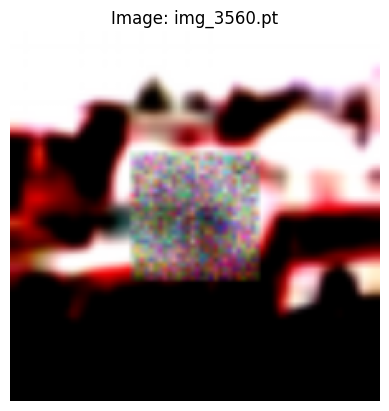

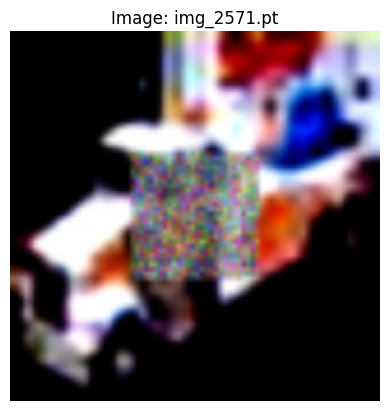

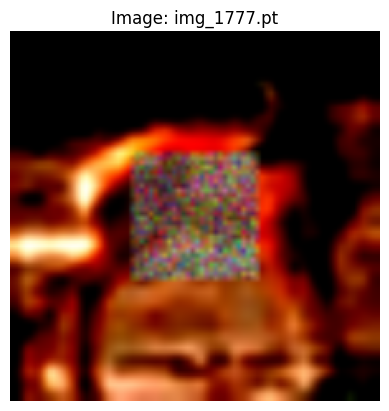

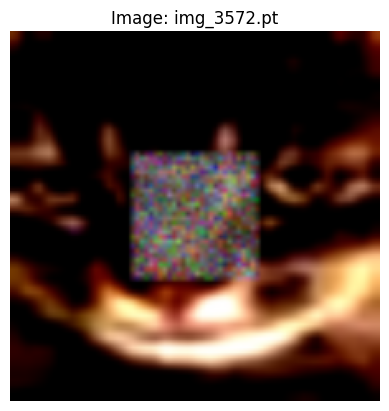

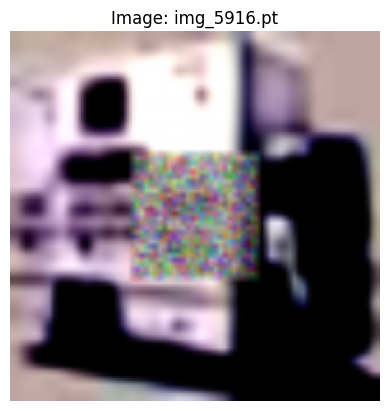

In [26]:
# Example usage
tensors_folder = "/content/noisy_dataset/content/generated_dataset/images"
loaded_tensors_scrambled_cifar10 = load_and_display_images(tensors_folder, display_limit=5)

In [27]:
tensors_folder = "/content/noisy_dataset/content/generated_dataset/images"
tensor_files = [f for f in os.listdir(tensors_folder) if f.endswith('.pt')]

# accuracy = evaluate_model_on_custom_images(model, "Model Name", labels_dict, tensor_files, tensors_folder)

vit_accuracy_cifar10_noisy=evaluate_model_on_custom_images(cifar10_vit_model, "ViT", labels_dict,tensor_files, tensors_folder)
print("Vit accuracy on Noisy bias data",vit_accuracy_cifar10_noisy)


vgg_accuracy_cifar10_noisy = evaluate_model_on_custom_images(cifar10_vgg_model, "Vgg", labels_dict,tensor_files, tensors_folder)
print("Vgg accuracy on Noisy bias data",vgg_accuracy_cifar10_noisy)

<ipython-input-18-13f547395d0b>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


ViT Accuracy on Custom Images: 57.18%
Vit accuracy on Color bias data 0.5718


<ipython-input-18-13f547395d0b>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


Vgg Accuracy on Custom Images: 38.42%
Vgg accuracy on Color bias data 0.3842


In [28]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]




# Call the function for evaluation
# Make `device` a keyword argument:
clip_accuracy_noisy_cifar10 = evaluate_clip_model_on_custom_data(tensor_files, cifar10_classes, labels_dict, means=(0.4914, 0.4822, 0.4465), stds=(0.247, 0.2435, 0.2616), device=device)

print(f"CLIP Accuracy on Noisy Data: {clip_accuracy_noisy_cifar10 * 100:.2f}%")

Processed 1/10000 - Accuracy: 0.00%


<ipython-input-18-13f547395d0b>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path).to(device)  # Load the tensor image and move to devi

Processed 51/10000 - Accuracy: 50.98%
Processed 101/10000 - Accuracy: 41.58%
Processed 151/10000 - Accuracy: 39.07%
Processed 201/10000 - Accuracy: 43.28%
Processed 251/10000 - Accuracy: 42.23%
Processed 301/10000 - Accuracy: 43.85%
Processed 351/10000 - Accuracy: 42.74%
Processed 401/10000 - Accuracy: 41.90%
Processed 451/10000 - Accuracy: 41.69%
Processed 501/10000 - Accuracy: 42.12%
Processed 551/10000 - Accuracy: 41.74%
Processed 601/10000 - Accuracy: 40.77%
Processed 651/10000 - Accuracy: 41.47%
Processed 701/10000 - Accuracy: 41.37%
Processed 751/10000 - Accuracy: 41.01%
Processed 801/10000 - Accuracy: 40.70%
Processed 851/10000 - Accuracy: 40.89%
Processed 901/10000 - Accuracy: 40.51%
Processed 951/10000 - Accuracy: 40.17%
Processed 1001/10000 - Accuracy: 40.36%
Processed 1051/10000 - Accuracy: 40.53%
Processed 1101/10000 - Accuracy: 40.24%
Processed 1151/10000 - Accuracy: 40.83%
Processed 1201/10000 - Accuracy: 40.72%
Processed 1251/10000 - Accuracy: 40.53%
Processed 1301/10000

In [29]:
vit_noisy_bias = vit_accuracy_cifar10_noisy/cifar10_vit_accuracy
vgg_noisy_bias = vgg_accuracy_cifar10_noisy/cifar10_vgg_accuracy
clip_noisy_bias = clip_accuracy_noisy_cifar10/cifar10_clip_accuracy

# vit_accuracy_cifar10_noisy,vgg_accuracy_cifar10_noisy,clip_accuracy_noisy_cifar10

print('vit_color_bias',vit_noisy_bias)
print('vgg_color_bias',vgg_noisy_bias)
print('clip_color_bias',clip_noisy_bias)



vit_color_bias 0.600047424847593
vgg_color_bias 0.4480089698668535
clip_color_bias 0.4642352941176471


In [30]:
print('cifar10_vit_accuracy',cifar10_vit_accuracy)
print('cifar10_vgg_accuracy',cifar10_vgg_accuracy)
print('cifar10_clip_accuracy',cifar10_clip_accuracy)
print('vit_accuracy_cifar10_noisy',vit_accuracy_cifar10_noisy)
print("vgg_accuracy_cifar10_noisy",vgg_accuracy_cifar10_noisy)
print('clip_accuracy_noisy_cifar10',clip_accuracy_noisy_cifar10)

cifar10_vit_accuracy 0.9529246794871795
cifar10_vgg_accuracy 0.8575721153846154
cifar10_clip_accuracy 0.85
vit_accuracy_cifar10_noisy 0.5718
vgg_accuracy_cifar10_noisy 0.3842
clip_accuracy_noisy_cifar10 0.3946


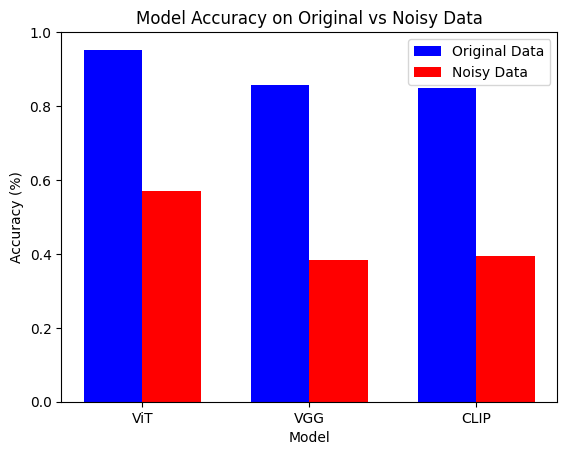

In [8]:
import matplotlib.pyplot as plt

# Bar Graph
models = ['ViT', 'VGG', 'CLIP']
# original_accuracies = [cifar10_vit_accuracy, cifar10_vgg_accuracy, cifar10_clip_accuracy]
original_accuracies = [0.9529246794871795, 0.8575721153846154, 0.85]
# color_bias_accuracies = [vit_accuracy_cifar10_noisy,vgg_accuracy_cifar10_noisy,clip_accuracy_noisy_cifar10]
color_bias_accuracies = [0.5718,0.3842,0.3946]

x = range(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x, original_accuracies, width, label='Original Data', color='blue')
bar2 = ax.bar([i + width for i in x], color_bias_accuracies, width, label='Noisy Data', color='red')

# Labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy on Original vs Noisy Data')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(models)
ax.legend()

# Show the bar graph
plt.show()
